# SARCASM DETECTION

In this notebook, we will build and train a deep learning model to detect sarcasm in text data. Sarcasm detection is a fascinating natural language processing (NLP) problem with applications in sentiment analysis, social media monitoring, and more.

We will use the IMDB Reviews Dataset, which contains movie reviews labeled as sarcastic or not. Our goal is to develop a binary classifier that can accurately identify sarcastic statements.

In [68]:
import json
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Downloading the dataset

In [69]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-09-28 19:00:06--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.1’

sarcasm.json.1      100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2023-09-28 19:00:06 (93.1 MB/s) - ‘sarcasm.json.1’ saved [5643545/5643545]



In [70]:
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Hyperparameters

In [89]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

## Splitting the dataset

This dataset has 27,000 records. We'll train on 20,000 and validate on the rest.

In [71]:
train_sentences = sentences[0:training_size]
test_sentences = sentences[training_size:]

train_labels = labels[0:training_size]
test_labels = labels[training_size:]

## Preprocessing

In [73]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [81]:
train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

## Building and Training the Model

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [83]:
# Compiling the model
model.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_7  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
num_epochs = 30

# Training the model
history = model.fit(train_padded, train_labels,
                    epochs = num_epochs,
                    validation_data = (test_padded, test_labels),
                    verbose = 1)

Epoch 1/30
625/625 [==============================] - 3s 3ms/step - loss: 0.5911 - accuracy: 0.6790 - val_loss: 0.4230 - val_accuracy: 0.8253
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.3325 - accuracy: 0.8651 - val_loss: 0.3482 - val_accuracy: 0.8533
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2504 - accuracy: 0.9017 - val_loss: 0.3402 - val_accuracy: 0.8556
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2037 - accuracy: 0.9212 - val_loss: 0.3499 - val_accuracy: 0.8532
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1706 - accuracy: 0.9365 - val_loss: 0.3694 - val_accuracy: 0.8547
Epoch 6/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1456 - accuracy: 0.9480 - val_loss: 0.3949 - val_accuracy: 0.8481
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1259 - accuracy: 0.9557 - val_loss: 0.4292 - val_accuracy: 0.8442
Epoch 

## Visualizing the Results

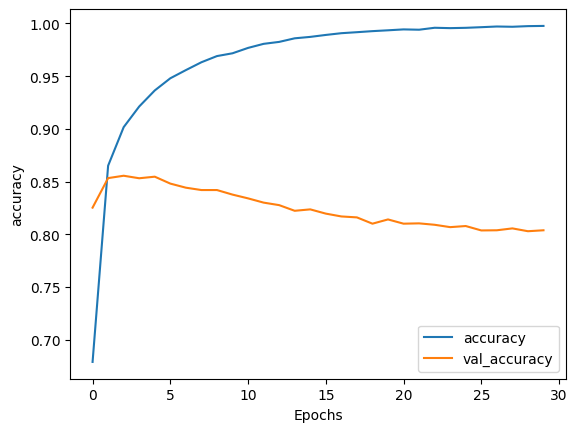

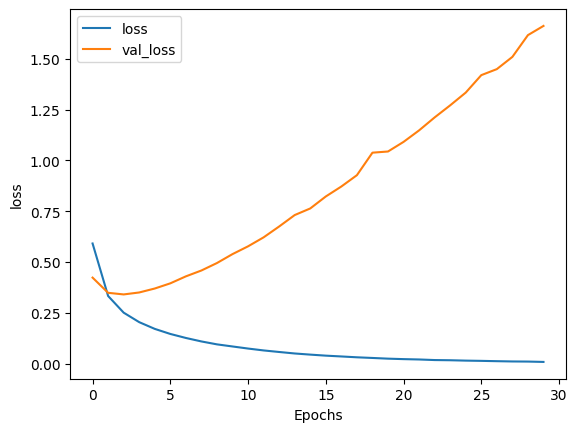

In [85]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Visualizing Word Embeddings

In [86]:
reverse_word_index = tokenizer.index_word

embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

print(embedding_weights.shape)

(10000, 16)


In [87]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):
    word_name = reverse_word_index[word_num]
    word_embedding = embedding_weights[word_num]

    out_m.write(word_name + '\n')
    out_v.write('\t'.join([str(x) for x in word_embedding]) + '\n')

out_v.close()
out_m.close()

In [88]:
# Import files utilities in Colab

try:
    from google.colab import files
except ImportError:
    pass

# Download the files
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can go to the [Tensorflow Embedding Projector](https://projector.tensorflow.org/) and load the two files you downloaded to see the visualization.